In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

from admm_approximate_solver import Approximate_ReLU_ADMM_Solver
from relu_utils import squared_loss, classifcation_accuracy

In [2]:
# generate toy data trying to fit noisy data to cosine
data = pd.read_csv("test_data/winequality-red.csv", delimiter=";")
X = np.array(data)[:,:11]
y = np.array(data.quality)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

n_train, d = X_train.shape
n_test = X_test.shape[0]

print(f"n train = {n_train}")
print(f"n test = {n_test}")

m = 10

n train = 1279
n test = 320


NONCONVEX PROBLEM WEIGHTS:
Train loss: 415.49999999999994
Train accuracy: 0.5332290852228303
Test loss: 108.49999999999999
Test accuracy: 0.49375


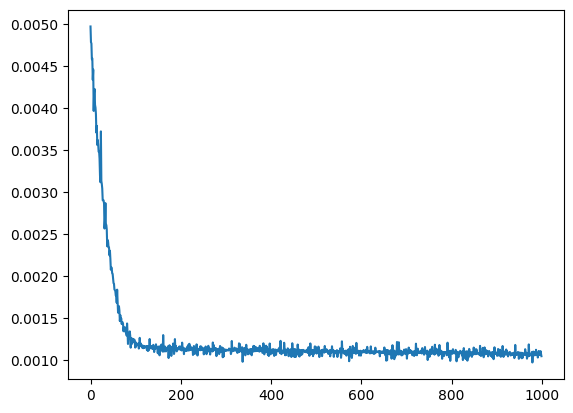

In [3]:
# TODO still need to optimize lr and batch_size

# Try to use GPU 
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Training params
lr = 1e-3
batch_size = 2 ** 10
epochs = 500

# Network
MLP = nn.Sequential(nn.Linear(d, m),
                    nn.ReLU(),
                    nn.Linear(m, np.max(y)+1)).to(dev)

# Train/Test data to torch
X_train_torch = torch.as_tensor(X_train, dtype=torch.float32)
y_train_torch = torch.as_tensor(y_train, dtype=torch.float32)
X_test_torch = torch.as_tensor(X_test, dtype=torch.float32)
y_test_torch = torch.as_tensor(y_test, dtype=torch.float32)
trainset = TensorDataset(X_train_torch, y_train_torch)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True)

# Optimizer and loss
optim = torch.optim.Adam(MLP.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

# Train
losses = []
for epoch in range(epochs):
    print(f'Epoch {epoch+1}/{epochs}', end='\r', flush=True)
    for sample, label in iter(trainloader):

        # Move to device
        sample = sample.to(dev)
        label = label.to(dev)

        # predict 
        pred = MLP(sample)

        # Back prop
        loss = loss_func(pred, label.long())
        loss.backward()
        optim.step()
        optim.zero_grad()
        losses.append(float(loss) / batch_size)

# Show trianing curve 
plt.plot(losses)

# Prediction
with torch.no_grad():
    y_hat_train = np.argmax(MLP(X_train_torch.to(dev)).to('cpu').numpy(), axis=-1)
    y_hat_test = np.argmax(MLP(X_test_torch.to(dev)).to('cpu').numpy(), axis=-1)

# Show results
print("NONCONVEX PROBLEM WEIGHTS:")
print(f"Train loss: {squared_loss(y_hat_train, y_train)}")
print(f"Train accuracy: {classifcation_accuracy(y_hat_train, y_train)}")
print(f"Test loss: {squared_loss(y_hat_test, y_test)}")
print(f"Test accuracy: {classifcation_accuracy(y_hat_test, y_test)}")

Solver doesn't converge well... Things needing fixing right now: 

- How to choose m, P_S?
- How to choose parameters $\rho$, step=$\gamma_{\alpha}$, $\beta$? 
- Converting from optimal weights $v, w$ to $u, \alpha$. Currently loss during training is consistently high but gets lower when calling .predict
- Runtime warning - divide by zero in optimizer. need to figure out why / fix

In [6]:
# solve cvx problem
m = 10
P_S = 20
rho = 0.0001
step = 0.00001
beta = 0.0001
bias = True
max_iter = 100
seed = 364

solver = Approximate_ReLU_ADMM_Solver(m=m,
                                      P_S=P_S,
                                      rho=rho,
                                      step=step,
                                      beta=beta,
                                      bias=bias,
                                      loss_func=squared_loss,
                                      acc_func=classifcation_accuracy,
                                      seed=seed)

solver.optimize(X_train, y_train, max_iter=max_iter, verbose=False)

print("ADMM SOLVER PERFORMANCE:")
y_hat_train = solver.predict(X_train, weights="C-ReLU")
y_hat_test = solver.predict(X_test, weights="C-ReLU")
print(f"Train loss: {squared_loss(y_hat_train, y_train)}")
print(f"Train accuracy: {classifcation_accuracy(y_hat_train, y_train)}")
print(f"Test loss: {squared_loss(y_hat_test, y_test)}")
print(f"Test accuracy: {classifcation_accuracy(y_hat_test, y_test)}")

solver = Approximate_ReLU_ADMM_Solver(m=m,
                                      P_S=P_S,
                                      rho=rho,
                                      step=step,
                                      beta=beta,
                                      bias=bias,
                                      loss_func=squared_loss,
                                      acc_func=classifcation_accuracy,
                                      seed=seed,
                                      use_cvxpy=True)

solver.optimize(X_train, y_train, max_iter=max_iter, verbose=False)


print("CVXPY SOLVER PERFORMANCE:")
y_hat_train = solver.predict(X_train, weights="C-ReLU")
y_hat_test = solver.predict(X_test, weights="C-ReLU")
print(f"Train loss: {squared_loss(y_hat_train, y_train)}")
print(f"Train accuracy: {classifcation_accuracy(y_hat_train, y_train)}")
print(f"Test loss: {squared_loss(y_hat_test, y_test)}")
print(f"Test accuracy: {classifcation_accuracy(y_hat_test, y_test)}")

Network of width 10 has 10 nonzero neurons for non-convex weights.
ADMM SOLVER PERFORMANCE:
Train loss: 223.7803261888969
Train accuracy: 0.6395621579358874
Test loss: 61.74047757747313
Test accuracy: 0.596875
Network of width 10 has 10 nonzero neurons for non-convex weights.
CVXPY SOLVER PERFORMANCE:
Train loss: 223.26428143421572
Train accuracy: 0.6348709929632526
Test loss: 62.27498473537075
Test accuracy: 0.59375
